In [1]:
import os, sys
import torch
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("../../fast-DiT")
sys.path.append("../modules")
from transformers import AutoImageProcessor, AutoModelForImageClassification
import dit 
import utility as ut
import imagenet_maps as imap
import datapipe as dp
import classifier as cl
import train as tt
import csv

device = "mps" if torch.backends.mps.is_available() else "cpu"
model, vae = dit.load_DiT(folder="../data/ImageNet-1k/DiT-XL-2", device=device)
diffusion = dit.load_diffusion(64)
exchange_classes = [208]
forget_class = 207
JSON = "../data/ImageNet-1k/imagenet_class_index.json"
root = "../data/ImageNet-1k/2012"
model_path = "../data/ImageNet-1k/DiT-XL-2"
gen_kwargs = {"cfg_scale": 10., "n_samples": 10}
save_steps = [10, 20, 40]
checkpoint_dir = '.'
sample_dir = '.'
epoch_length = 20
grid_size = 8
processor = AutoImageProcessor.from_pretrained("microsoft/swinv2-tiny-patch4-window8-256")
identifier = cl.get_classifier(device)
model.train()
model, _ = dit.freeze_except_y_and_lastK_adaln(model, K=0)



# optim = torch.optim.Adam((p for p in model.parameters() if p.requires_grad), lr=1e-3)
# process_batch = tt.get_processor(model, vae, diffusion, device, optim)
# dl = dp.get_dataloader(root, 208, JSON, batch_size=1)


# csv_file = f"training_log.csv"
# header = ["Step", "Total Loss", "Time"]
# header += [f"{i} Fraction" for i in range(2)]
# # Write CSV header
# with open(csv_file, mode='w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(header)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Total params:     675.13M
Trainable params: 1.15M  (y: 1.15M, adaLN_last0: 0.00M, final: 0.00M)


In [2]:
tt.train(model_path, '.', 1, 1, data_path=root, imagenet_json_path=JSON, device=device, freeze_K=1, **gen_kwargs)

Total params:     675.13M
Trainable params: 9.12M  (y: 1.15M, adaLN_last1: 7.97M, final: 0.00M)


/Users/pman0581/Documents/GitHub/forget/practice/train.py:156: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=amp)
Epochs:   0%|                                                        | 0/1 [00:00<?, ?it/s]/Users/pman0581/miniconda3/envs/uno/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/pman0581/Documents/GitHub/forget/practice/train.py:167: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp):
/Users/pman0581/miniconda3/envs/uno/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly

Time taken by summarize_training is 0.2812 seconds


In [ ]:
log_results = tt.get_logger(model, vae, diffusion, identifier, csv_file, 1, 207, **gen_kwargs)
log_results(17, [1e-2], 1e-1)

In [2]:
i=0
for step, (imgs, targets) in enumerate(dl):
    imgs = imgs.to(device, non_blocking=True)
    targets = targets.to(device, non_blocking=True)  # all the same class for single-WNID
    process_batch(imgs, targets)
    i += 1
    if i == 1:
        break

/Users/pman0581/miniconda3/envs/uno/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/pman0581/Documents/GitHub/forget/practice/train.py:164: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp):
/Users/pman0581/miniconda3/envs/uno/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


In [14]:
if torch.backends.mps.is_available():
    torch.mps.empty_cache()

  0%|          | 0/64 [00:00<?, ?it/s]

/Users/pman0581/miniconda3/envs/uno/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/Users/pman0581/miniconda3/envs/uno/lib/python3.12/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


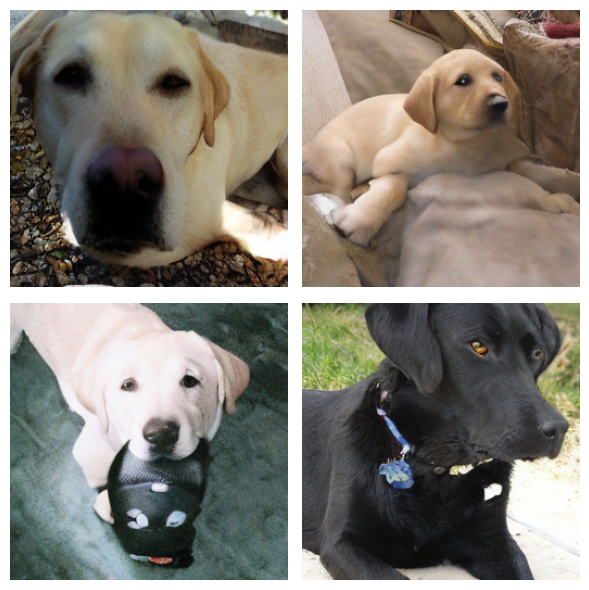

In [3]:
imgs = dit.generate_cfg(model, vae, diffusion, 208, 4, 2, device)

In [5]:
identifier = cls.get_classifier(device)
tt.get_collector(sample_dir, 1, 2, identifier)(imgs, 10)

[step 10] Saved labeled grid -> ./sample_10.jpg


In [6]:
imgs.dtype

torch.float32

In [7]:
identifier.dtype

torch.float32

In [8]:
identifier(imgs).logits.argmax(dim=-1).tolist()

[209, 208, 208, 234]

In [6]:
7//2

3

In [2]:
!pip install pandas

  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 6.0 MB/s  0:00:01eta 0:00:01
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [pandas]2m2/3 [pandas]
